# Wood-Berry (1973) Distillation Model

This notebook describes how to study the relationship between inputs and outputs in a MIMO system. We will be using the Wood-Berry Distillation Model.

Details of the model is available in **Loquasto and Seborg (2013) [1]**:

> The Wood-Berry model is a well-known 2 × 2 transfer function model of a pilot-plant distillation column for a methanol-water mixture. The output variables are the distillate and bottoms compositions, $x_D$ and $x_B$ [weight % methanol]. They are controlled by manipulating the reflux and steam flow rates, $R$ and $S$ [lb/min]. The feed flow rate, $F$, is an unmeasured disturbance variable.


References:

1. See Case Study 5: [Loquasto, Fred, and Dale E. Seborg. "Monitoring model predictive control systems using pattern classification and neural networks." *Industrial & engineering chemistry research* 42.20 (2003): 4689-4701.](http://www.chemengr.ucsb.edu/~ceweb/faculty/seborg/pdfs/Loquasto_IEC.pdf)

2. Other models available in [Khaki-Sedigh A., Moaveni B. (2009) Appendix: Mathematical Models Used in Examples. In: Control Configuration Selection for Multivariable Plants. Lecture Notes in Control and Information Sciences, vol 391. Springer, Berlin, Heidelberg](https://link.springer.com/chapter/10.1007/978-3-642-03193-9_8)

In the previous notebook, we've built the MIMO system in the `control` library using a Pade approximation for the delay.

Recall that the model is in the following form:

$
\begin{bmatrix}
x_D(s) \\
x_B(s) 
\end{bmatrix}= 
\begin{bmatrix}
G_{11} & G_{12} \\
G_{21} & G_{22} 
\end{bmatrix}
\begin{bmatrix}
R(s) \\
S(s) 
\end{bmatrix}+
\begin{bmatrix}
G_{1F} \\
G_{2F} 
\end{bmatrix}
F(s)
$

### Define our Model
Here's the model that we built in the previous notebook.

In [408]:
g_tf = control.tf([12.8], [16.7,1])
td = 1
g_delay = control.tf(control.pade(td,1)[0],control.pade(td,1)[1])
g11 = g_tf*g_delay

g_tf = control.tf([-18.9], [21.0,1])
td = 3
g_delay = control.tf(control.pade(td,1)[0],control.pade(td,1)[1])
g12 = g_tf*g_delay

g_tf = control.tf([6.6], [10.9,1])
td = 7
g_delay = control.tf(control.pade(td,1)[0],control.pade(td,1)[1])
g21 = g_tf*g_delay

g_tf = control.tf([-19.4], [14.4,1])
td = 3
g_delay = control.tf(control.pade(td,1)[0],control.pade(td,1)[1])
g22 = g_tf*g_delay

g_tf = control.tf([3.8], [14.9,1])
td = 8
g_delay = control.tf(control.pade(td,1)[0],control.pade(td,1)[1])
g1f = g_tf*g_delay

g_tf = control.tf([4.9], [13.2,1])
td = 3
g_delay = control.tf(control.pade(td,1)[0],control.pade(td,1)[1])
g2f = g_tf*g_delay

row_1_num = [x[0][0] for x in (g11.num, g12.num, g1f.num)]
row_2_num = [x[0][0] for x in (g21.num, g22.num, g2f.num)]

row_1_den = [x[0][0] for x in (g11.den, g12.den, g1f.den)]
row_2_den = [x[0][0] for x in (g21.den, g22.den, g2f.den)]

sys = control.tf(
    [row_1_num,row_2_num],
    [row_1_den,row_2_den]
)

sys


Input 1 to output 1:
    -12.8 s + 25.6
---------------------
16.7 s^2 + 34.4 s + 2

Input 1 to output 2:
      -6.6 s + 1.886
---------------------------
10.9 s^2 + 4.114 s + 0.2857

Input 2 to output 1:
    18.9 s - 12.6
----------------------
21 s^2 + 15 s + 0.6667

Input 2 to output 2:
      19.4 s - 12.93
--------------------------
14.4 s^2 + 10.6 s + 0.6667

Input 3 to output 1:
      -3.8 s + 0.95
-------------------------
14.9 s^2 + 4.725 s + 0.25

Input 3 to output 2:
      -4.9 s + 3.267
-------------------------
13.2 s^2 + 9.8 s + 0.6667

## Step Response
We know that this is a $3\times2$ MIMO system, there are 3 inputs (2 MVs: reflux and reboiler steam flow rates, and one FF variable: feed flow rate) and 2 outputs (2 DVs: top composition, bottom composition).

To get the relationship between the MVs and DVs, we can perform a bump test using `control.step_response`.

### Bump test on reflux, $R(s)$:

Import libraries:

In [410]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
T = np.linspace(0,200,1000)       # Define timescale for the bump test

In [411]:
T, y_R = control.step_response(sys,T,input=0)

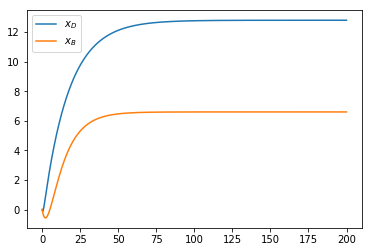

In [412]:
plt.plot(T, y_R[0], label='$x_D$')
plt.plot(T, y_R[1], label='$x_B$')
plt.legend()

### Bump test on reboiler steam, $S(s)$:

In [413]:
T, y_S = control.step_response(sys,T,input=1)

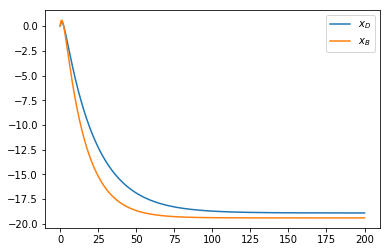

In [414]:
plt.plot(T, y_S[0], label='$x_D$')
plt.plot(T, y_S[1], label='$x_B$')
plt.legend()

We can see their relationship more clearly in a 4x4 plot of DVs against MVs:

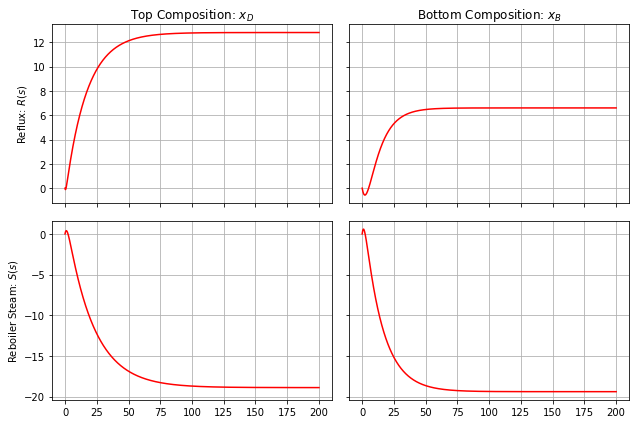

In [415]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(9,6))
ax1.plot(T, y_R[0], label='$x_D$', color='r')
ax2.plot(T, y_R[1], label='$x_B$', color='r')
ax3.plot(T, y_S[0], label='$x_D$', color='r')
ax4.plot(T, y_S[1], label='$x_B$', color='r')

ax1.set_title('Top Composition: $x_D$')
ax2.set_title('Bottom Composition: $x_B$')
ax1.set_ylabel('Reflux: $R(s)$')
ax3.set_ylabel('Reboiler Steam: $S(s)$')

ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid(); 
plt.tight_layout()

## Takeaways:

By the end of this notebook, you should be able to:

1. Obtain the step response of a MIMO system using `control.step_response`.
2. Plot the step response of a MIMO system to study the relationship between inputs and outputs